2.264302669819447 3.7837058364905802
7


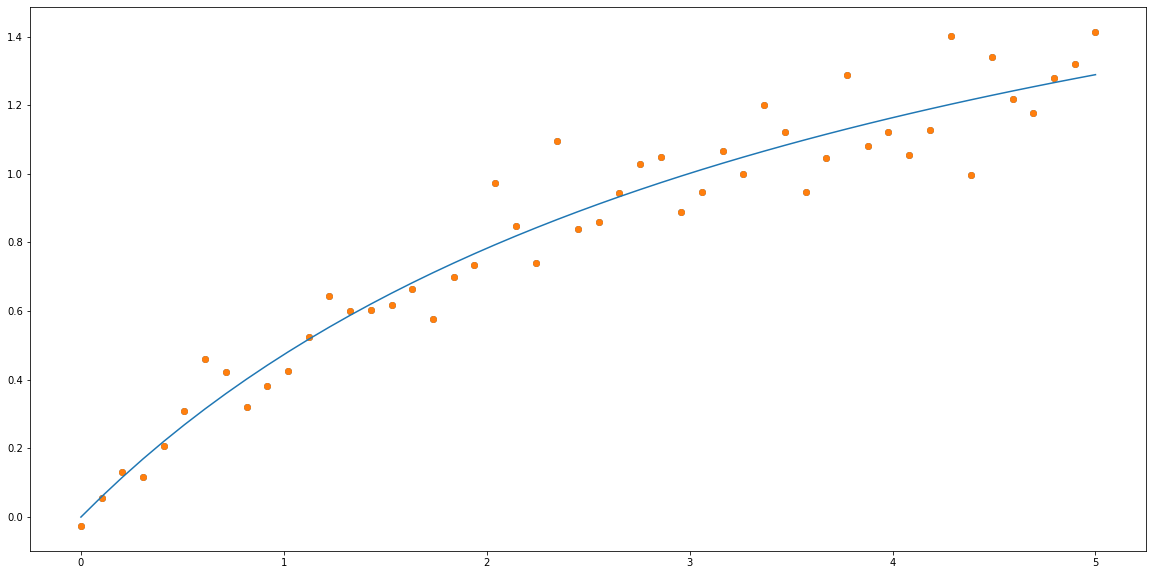

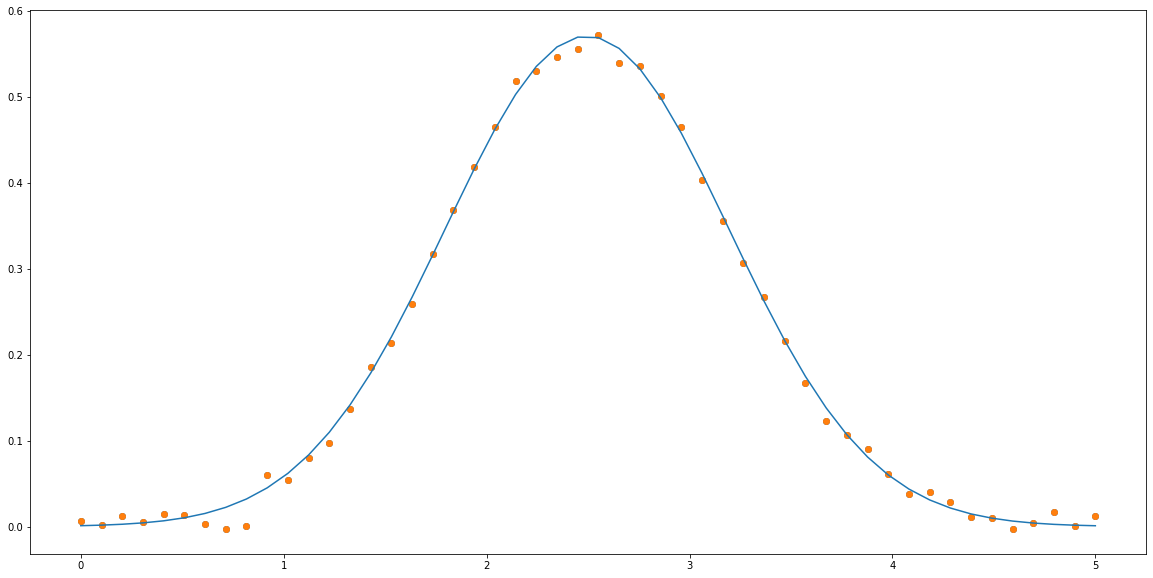

2.4949531094975463 0.48924335232913413
5
dogleg
0.999999999999993 0.9999999999999859 25
gauss
1.0662895334940152 1.0662895334940152 46


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.optimize import least_squares

# Gauss-Newton

def one_dim_function(a, b, x):
    return a * x / (b + x)

f1 = one_dim_function

x = np.linspace(0, 5, 50)
y = f1(2, 3, x) + np.random.normal(0, 0.1, size=50)

plt.scatter(x, y)

def grad_a(f, a, b, x):
    eps = 1e-6
    return (f(a + eps, b, x) - f(a - eps, b, x)) / (2 * eps)

def grad_b(f, a, b, x):
    eps = 1e-6
    return (f(a, b + eps, x) - f(a, b - eps, x)) / (2 * eps)

def jacobian(f, a, b, x):
    return np.column_stack([grad_a(f, a, b, x), grad_b(f, a, b, x)])

def gauss_newton(f, x, y, start, max_norm, max_iter):
    new = start
    for i in range(max_iter):
        old = new
        j = jacobian(f, old[0], old[1], x)
        r = y - f(old[0], old[1], x)
        new = old + np.linalg.inv(j.T@j)@j.T@r
        if np.linalg.norm(old - new) < max_norm:
            break
    return new, i

ar, j = gauss_newton(f1, x, y, np.array([5, 1]), 1e-5, 10)

print(ar[0], ar[1])
print(j)

plt.scatter(x, y)
plt.plot(x, f1(ar[0], ar[1], x))
plt.show()

def normal(a, b, x):
    return (1 / np.sqrt(2 * np.pi * b)) * np.exp(-0.5 * (1 / b) * (x - a) ** 2)

f2 = normal

y = f2(2.5, 0.5, x) + np.random.normal(0, 0.01, size=50)

plt.scatter(x, y)

ar, j = gauss_newton(f2, x, y, np.array([3, 1]), 1e-5, 10)
plt.scatter(x, y)
plt.plot(x, f2(ar[0], ar[1], x))
plt.show()

print(ar[0], ar[1])
print(j)

# Dogleg

def dogleg_method(Hk, gk, Bk, trust_radius):
    pB = -np.dot(Hk, gk)
    norm_pB = sqrt(np.dot(pB, pB))

    if norm_pB <= trust_radius:
        return pB

    pU = - (np.dot(gk, gk) / np.dot(gk, np.dot(Bk, gk))) * gk
    dot_pU = np.dot(pU, pU)
    norm_pU = sqrt(dot_pU)

    if norm_pU >= trust_radius:
        return trust_radius * pU / norm_pU

    pB_pU = pB - pU
    dot_pB_pU = np.dot(pB_pU, pB_pU)
    dot_pU_pB_pU = np.dot(pU, pB_pU)
    fact = dot_pU_pB_pU ** 2 - dot_pB_pU * (dot_pU - trust_radius ** 2)
    tau = (-dot_pU_pB_pU + sqrt(fact)) / dot_pB_pU

    return pU + tau * pB_pU

def trust_region_dogleg(func, jac, hess, x0, initial_trust_radius=1.0,
                        max_trust_radius=100.0, eta=0.15, gtol=1e-4,
                        maxiter=100):
    tr = []
    xk = x0
    trust_radius = initial_trust_radius
    k = 0
    while True:
        tr.append(xk)
        gk = jac(xk)
        Bk = hess(xk)
        Hk = np.linalg.inv(Bk)

        pk = dogleg_method(Hk, gk, Bk, trust_radius)

        act_red = func(np.array(xk)) - func(np.array(xk + pk))

        pred_red = -(np.dot(gk, pk) + 0.5 * np.dot(pk, np.dot(Bk, pk)))

        rhok = act_red / pred_red
        if pred_red == 0.0:
            rhok = 1e99
        else:
            rhok = act_red / pred_red

        norm_pk = sqrt(np.dot(pk, pk))

        if rhok < 0.25:
            trust_radius = 0.25 * norm_pk
        else:
            if rhok > 0.75 and norm_pk == trust_radius:
                trust_radius = min(2.0 * trust_radius, max_trust_radius)
            else:
                trust_radius = trust_radius

        if rhok > eta:
            xk = xk + pk
        else:
            xk = xk

        if linalg.norm(gk) < gtol:
            break

        if k >= maxiter:
            break
        k = k + 1
    return xk, k - 1, np.asarray(tr)

def f(x):
    return 1 - x[0] + 10 * (x[1] - x[0]**2)

"(100 * (y - x ^ 2) ^ 2 + (1 - x) ^ 2)"

def f_sqr(x):
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

def f_sqr_2(x):
    return np.array([(1 - x[0])**2, 100*(x[1] - x[0]**2)**2])

def jac(x):
    return np.array([-400 * (x[1] - x[0]**2) * x[0] - 2 + 2 * x[0], 200 * x[1] - 200 * x[0]**2])

def jac_2(x):
    return np.column_stack([[- 2 + 2 * x[0], 0], [-400 * (x[1] - x[0]**2) * x[0], 200 * x[1] - 200 * x[0]**2]])

def hess(x):
    return np.array([[1200 * x[0]**2 - 400 * x[1]+2, -400 * x[0]], [-400 * x[0], 200]])

print("dogleg")
result, iter, _ = trust_region_dogleg(f_sqr, jac, hess, [3, 3])
print(result[0], result[1], iter)

def gauss_newton_2(f, start, jac, max_norm, max_iter):
    new = start
    for i in range(max_iter):
        old = new
        j = jac(old)
        r = f(old)
        new = old + 1 / (j.T@j) * j.T@r
        if np.linalg.norm(old - new) < max_norm:
            break
    return new, i

print("gauss")
result, it = gauss_newton_2(f_sqr_2, np.array([3, 3]), jac, 1e-2, 200)
print(result[0], result[1], it)



In [52]:
import scipy as sp
from matplotlib.colors import ListedColormap
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tracemalloc
from numpy import linalg as LA
from math import sqrt
from matplotlib.colors import ListedColormap

plt.rcParams["figure.figsize"] = (20, 10)

phi = (sqrt(5) - 1) / 2

eps=1e-6

def golden_search(f):
    def step(old_interval, f_x1=None, f_x2=None, cnt = 0):
        a, b = old_interval

        if b - a < eps:
            mid = (a + b) / 2
            return mid

        t = (b - a) * phi
        x1, x2 = b - t, a + t

        f_x1 = f_x1 if f_x1 else f(x1)
        f_x2 = f_x2 if f_x2 else f(x2)

        if f_x1 < f_x2:
            new_interval = (a, x2)
            args = [None, f_x1]
        else:
            new_interval = (x1, b)
            args = [f_x2, None]

        return step(new_interval, *args, cnt + 1)

    return step

def common_gd(f, derivative, x0, method, step_method, iteration=20_000, eps=1e-5):
    xk = x0
    p_i = np.zeros(len(x0))
    v_i = np.zeros(len(x0))
    trace = [xk]
    for i in range(iteration):
        x_next, p_i, v_i = step_method(f, derivative, method, xk, p_i, v_i)
        trace.append(x_next)

        if LA.norm(derivative(*x_next)) < eps:
            return i, np.asarray(trace), x_next

        xk = x_next
    return iteration, np.asarray(trace), None

def plot_graph(f, trace):
    fig, ax = plt.subplots()

    x, y = np.mgrid[-2:2:1000j, -1:4:1000j]
    z = f(x, y)

    levels = [x ** 3 for x in range(8)]
    r = np.linspace(240, 166, 256) / 255.
    g = np.linspace(244, 188, 256) / 255.
    b = np.linspace(246, 203, 256) / 255.
    cmap = ListedColormap(np.vstack((r, g, b)).T)

    ax.contourf(x, y, z, levels=10, cmap=cmap)
    cs = ax.contour(x, y, z, levels=levels, colors="#ABBECC")
    ax.clabel(cs, colors="#2618B1")

    ax.plot(trace[:, 0], trace[:, 1], '-og', linewidth=.5, ms=1.5)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid()

    fig.set_figwidth(10)
    fig.set_figheight(12)

    plt.show()

def plot_all_graph(f, trace, step_representation):
    fig, ax = plt.subplots()
    x, y = np.mgrid[-2:4:1000j, -1:5:1000j]
    z = f(x, y)

    levels = [x ** 3 for x in range(8)]
    r = np.linspace(240, 166, 256) / 255.
    g = np.linspace(244, 188, 256) / 255.
    b = np.linspace(246, 203, 256) / 255.
    cmap = ListedColormap(np.vstack((r, g, b)).T)

    ax.contourf(x, y, z, levels=10, cmap=cmap)
    cs = ax.contour(x, y, z, levels=levels, colors="#ABBECC")
    ax.clabel(cs, colors="#2618B1")
    color = ["b", "g", "r", "c", "y", "m"]
    for i in range(len(trace) - 2):
        ax.plot(trace[i][:, 0], trace[i][:, 1], '-o' + color[i], linewidth=1., ms=2, label=step_representation[i])
    ax.plot(trace[-2][:, 0], trace[-2][:, 1], '-o', color="orange", linewidth=1., ms=2, label=step_representation[-2])
    ax.plot(trace[-1][:, 0], trace[-1][:, 1], '-o', color="brown", linewidth=1., ms=2, label=step_representation[-1])
    # ax.legend(['1', "2"])
    #   b g r c m y
    ax.legend(prop={'size': 20})
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid()

    fig.set_figwidth(15)
    fig.set_figheight(20)

    plt.show()


def step(f, derivative, method, x, _, __):
   pk = -derivative(*x)
   g = lambda a: f(*(x + a * pk))
   ak = method(g)((0, 1.01))
   x_next = x + ak * pk
   return x_next, _, __

def step_with_momentum(f, derivative, method, x, p_prev, _):
    beta = 0.5
    pk = beta * p_prev + (1 - beta) * derivative(*x)
    g = lambda a: f(*(x - a * pk))
    ak = method(g)((0, 1.01))
    return x - ak * pk, pk, _

def step_nesterov(f, derivative, method, x, p_prev, _):
    beta = 0.3
    g = lambda a: f(*(x - beta * p_prev - a * derivative(*(x - beta * p_prev))))
    ak = method(g)((0, 1.01))
    return x - beta * p_prev - ak * derivative(*(x - beta * p_prev)), beta * p_prev - ak * derivative(*(x - beta * p_prev)), _

def step_ada(f, derivative, method, x, p_prev, _):
    d = derivative(*x)
    pk = p_prev + np.square(d)
    pt =  d / (np.sqrt(pk) + 1e-8)
    g = lambda a: f(*(x - a * pt))
    ak = method(g)((0, 1.01))
    return x - ak * pt, pk, _

def step_RMSProp(f, derivative, method, x, p_prev, _):
    gamma = 0.9
    d = derivative(*x)
    pk = gamma * p_prev + (1 - gamma) * np.square(d)
    pt = d / (np.sqrt(pk) + 1e-8)
    g = lambda a: f(*(x - a * pt))
    ak = method(g)((0, 1.01))
    return x - ak * pt, pk, _

def step_adam(f, derivative, method, x, p_prev, v_prev):
    beta1 = 0.9
    beta2 = 0.99
    d = derivative(*x)
    pk = beta1 * p_prev + (1 - beta1) * d
    vk = beta2 * v_prev + (1 - beta2) * np.square(d)
    pt = pk / (np.sqrt(vk) + 1e-8)
    g = lambda a: f(*(x - a * pt))
    ak = method(g)((0, 1.01))
    return x - ak * pt, pk, vk


fs = [lambda x, y: 5 * (y - x) ** 2 + (1 - x) ** 2,
      lambda x, y: 100 * (y - x ** 2) ** 2 + (1 - x) ** 2]

derivatives = [lambda x, y: np.array([-10 * (y - x) + 2 * x - 2, 10 * (y - x)]),
               lambda x, y: np.array([2 * (-1 + x + 200 * x ** 3 - 200 * x * y), 200 * (-x ** 2 + y)])]


steps = [step, step_with_momentum, step_nesterov, step_ada, step_RMSProp, step_adam]
step_representation = ["step", "step_with_momentum", "step_nesterov", "step_ada", "step_RMSProp", "step_adam", "bfgs", "dogleg"]


def bfgs_method(f, grad, x0, steps=1000, eps=1e-6):
    grad_k = grad(x0)
    I = np.eye(len(x0), dtype=int)
    Hk = I
    xk = x0
    points = []
    for i in range(steps):
        points.append(xk)
        if LA.norm(grad_k) <= eps:
            return xk, i + 1, np.asarray(points)
        pk = -np.dot(Hk, grad_k) # direction of search
        try:
            sk = sp.optimize.line_search(f, grad, xk, pk)[0] * pk # coefficient satisfies the Wolfe conditions
        except TypeError:
            return None, i + 1, np.asarray(points)
        xk = xk + sk

        grad_cur = grad(xk)
        yk = grad_cur - grad_k
        grad_k = grad_cur

        coef = 1.0 / np.dot(yk, sk)
        Hk = np.dot(
            I - coef * sk[:, np.newaxis] * yk[np.newaxis, :],
            np.dot(Hk, I - coef * yk[:, np.newaxis] * sk[np.newaxis, :])) \
             + (coef * sk[:, np.newaxis] * sk[np.newaxis, :]) # next hessian
    return None, None, np.asarray(points)


fs_simple = [lambda x: 5 * (x[1] - x[0]) ** 2 + (1 - x[0]) ** 2,
             lambda x: 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2,
             ]

fs_simple2 = [lambda x: np.array([sqrt(5) * (x[1] - x[0]), (1 - x[0])]),
              lambda x: np.array([10 * (x[1] - x[0] ** 2), (1 - x[0])]),
             ]

derivatives_simple = [lambda x: np.array([-10 * (x[1] - x[0]) + 2 * x[0] - 2, 10 * (x[1] - x[0])]),
                      lambda x: np.array([2 * (-1 + x[0] + 200 * x[0] ** 3 - 200 * x[0] * x[1]), 200 * (-x[0] ** 2 + x[1])]),
                      ]

hessians = [lambda x: np.array([[12, -10], [-10, 10]]),
            lambda x: np.array([[1200 * x[0]**2 - 400 * x[1]+2, -400 * x[0]], [-400 * x[0], 200]]),
            ]

representations = ["5 * (y - x) ^ 2 + (1 - x) ^ 2",
                   "(100 * (y - x ^ 2) ^ 2 + (1 - x) ^ 2)"]

starts = np.array([[0, 0], [-1, 1], [2, 3], [4, 1], [3, 5], [1, 10], [-1, -10]])


f = 5 * (y - x) ^ 2 + (1 - x) ^ 2:
Стартовая точка: [0 0]
step                          	 Ответ : [0.99999505 0.99999406]. Количество операций : 132. Время : 110 миллисекунд. Память : 89.073 KB
step_with_momentum            	 Ответ : [1.00000036 1.00000061]. Количество операций : 28. Время : 18 миллисекунд. Память : 22.347 KB
step_nesterov                 	 Ответ : [0.99999661 0.99999608]. Количество операций : 46. Время : 66 миллисекунд. Память : 23.285 KB
step_ada                      	 Ответ : [0.99999505 0.99999406]. Количество операций : 132. Время : 88 миллисекунд. Память : 64.868 KB
step_RMSProp                  	 Ответ : [0.99999505 0.99999406]. Количество операций : 132. Время : 93 миллисекунд. Память : 80.68 KB
step_adam                     	 Ответ : [1.00000407 1.00000392]. Количество операций : 113. Время : 87 миллисекунд. Память : 74.731 KB
dogleg                        	 Ответ : [1. 1.]. Количество операций : 4. Время : 1 миллисекунд. Память : 7.168 KB
gauss-newton 0.9999

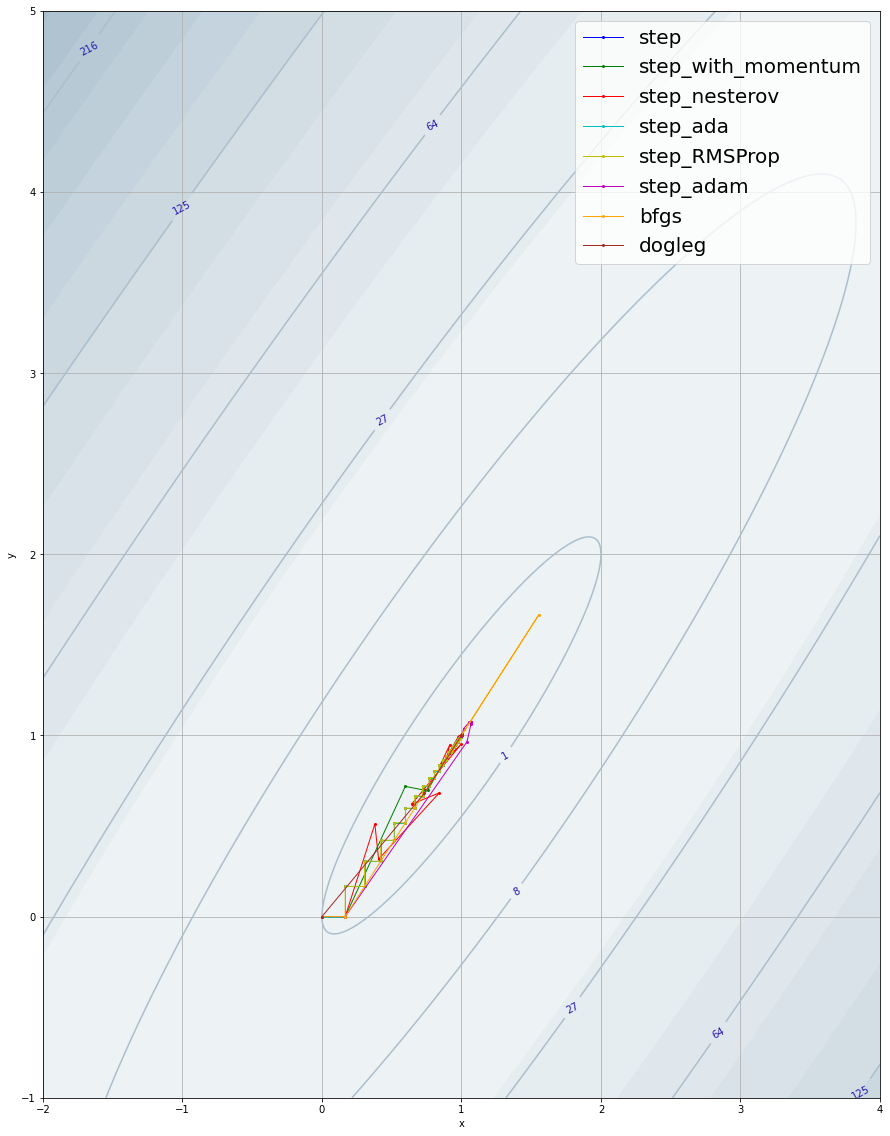

Стартовая точка: [-1  1]
step                          	 Ответ : [0.9999968  0.99999645]. Количество операций : 8. Время : 6 миллисекунд. Память : 13.795 KB
step_with_momentum            	 Ответ : [0.99999867 0.99999877]. Количество операций : 25. Время : 17 миллисекунд. Память : 20.259 KB
step_nesterov                 	 Ответ : [0.99999482 0.99999452]. Количество операций : 59. Время : 86 миллисекунд. Память : 37.755 KB
step_ada                      	 Ответ : [0.99999307 0.99999241]. Количество операций : 266. Время : 196 миллисекунд. Память : 99.531 KB
step_RMSProp                  	 Ответ : [0.9999957  0.99999485]. Количество операций : 132. Время : 101 миллисекунд. Память : 76.083 KB
step_adam                     	 Ответ : [0.99999804 0.99999836]. Количество операций : 150. Время : 226 миллисекунд. Память : 69.492 KB
dogleg                        	 Ответ : [1. 1.]. Количество операций : 4. Время : 1 миллисекунд. Память : 6.584 KB
gauss-newton 1.0000000000000002 0.9999999999616407 3

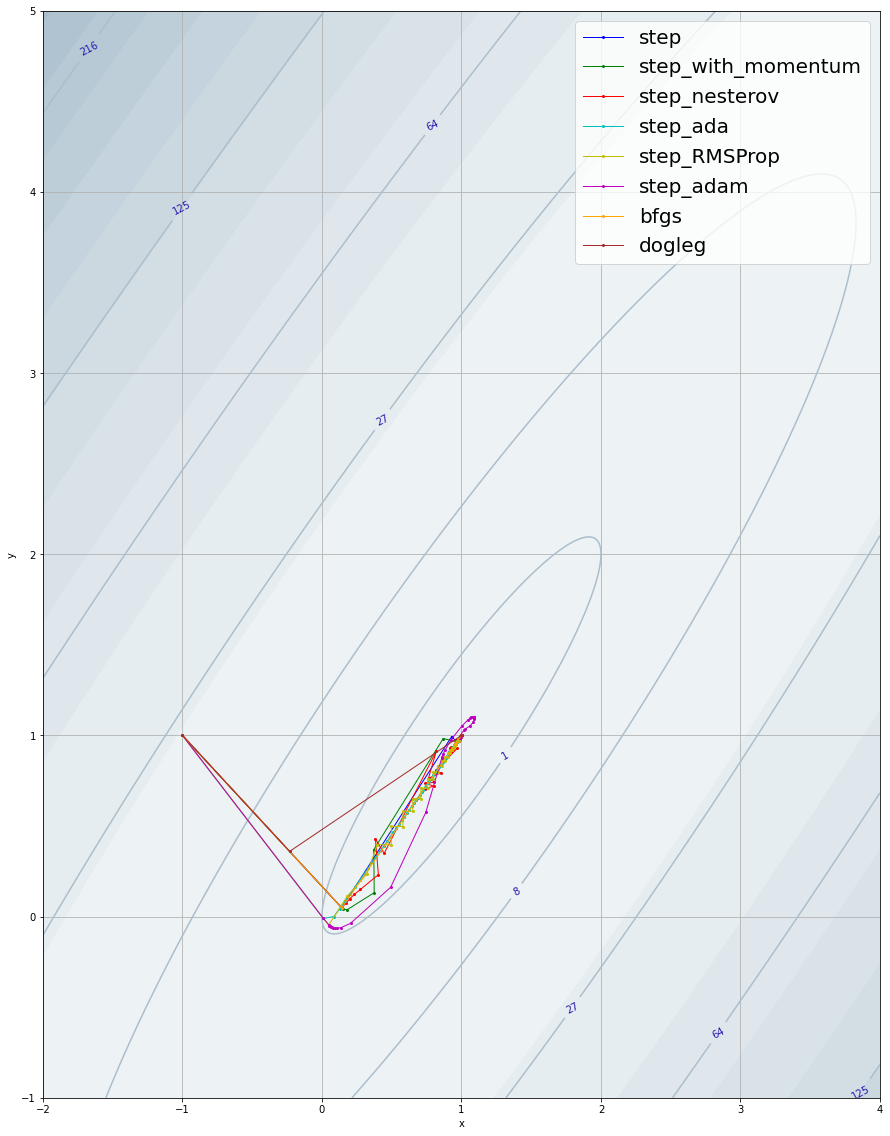

Стартовая точка: [2 3]
step                          	 Ответ : [1.00000273 1.00000297]. Количество операций : 24. Время : 16 миллисекунд. Память : 29.259 KB
step_with_momentum            	 Ответ : [1.00000426 1.00000421]. Количество операций : 29. Время : 19 миллисекунд. Память : 24.899 KB
step_nesterov                 	 Ответ : [1.00000438 1.00000504]. Количество операций : 57. Время : 77 миллисекунд. Память : 33.736 KB
step_ada                      	 Ответ : [1.00000545 1.00000563]. Количество операций : 140. Время : 88 миллисекунд. Память : 79.28 KB
step_RMSProp                  	 Ответ : [1.00000558 1.00000595]. Количество операций : 106. Время : 67 миллисекунд. Память : 75.944 KB
step_adam                     	 Ответ : [0.99999839 0.99999876]. Количество операций : 94. Время : 60 миллисекунд. Память : 70.912 KB
dogleg                        	 Ответ : [1. 1.]. Количество операций : 4. Время : 2 миллисекунд. Память : 7.055 KB
gauss-newton 1.0 1.0000000013542012 2
dogleg 1.0 1.0 1


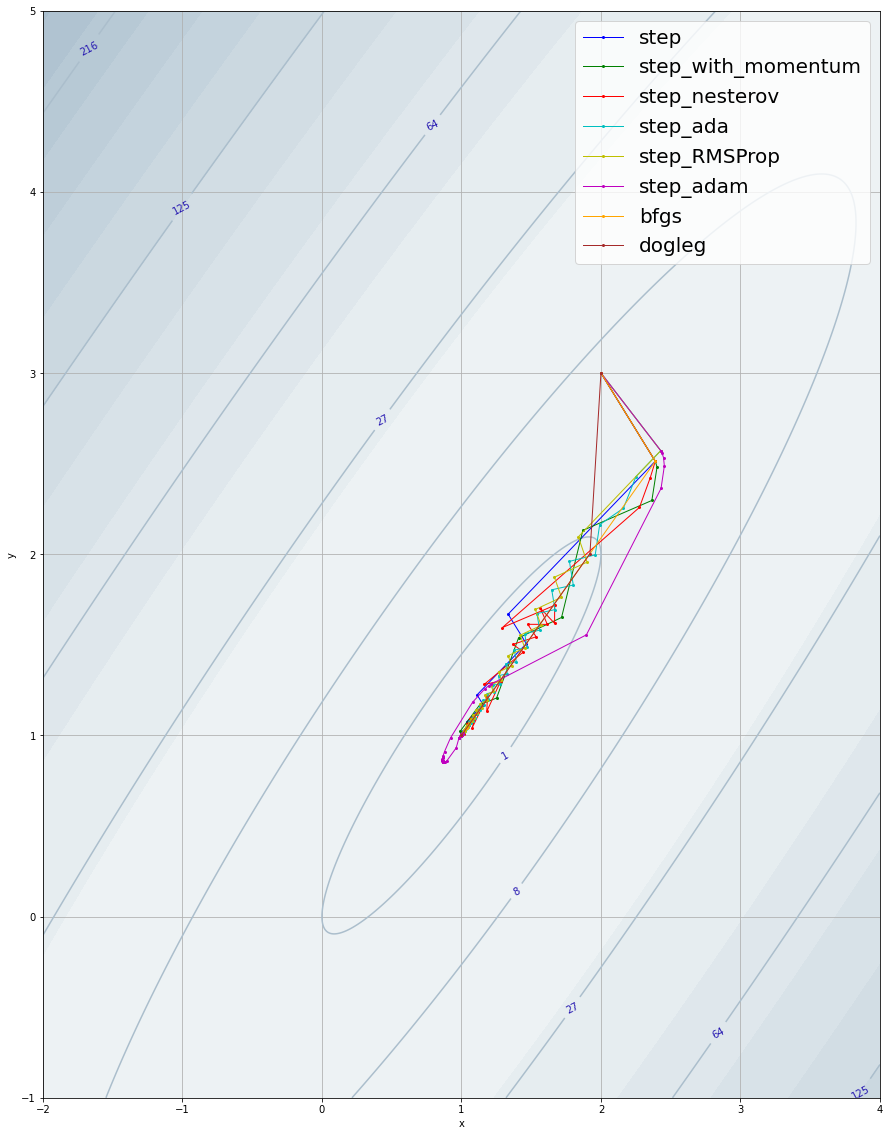

Стартовая точка: [4 1]
step                          	 Ответ : [1.0000048  1.00000533]. Количество операций : 8. Время : 6 миллисекунд. Память : 10.627 KB
step_with_momentum            	 Ответ : [1.000002   1.00000184]. Количество операций : 25. Время : 18 миллисекунд. Память : 20.259 KB
step_nesterov                 	 Ответ : [1.00000445 1.00000513]. Количество операций : 61. Время : 91 миллисекунд. Память : 38.698 KB
step_ada                      	 Ответ : [1.00000696 1.00000761]. Количество операций : 448. Время : 290 миллисекунд. Память : 125.131 KB
step_RMSProp                  	 Ответ : [1.00000488 1.00000574]. Количество операций : 130. Время : 84 миллисекунд. Память : 82.248 KB
step_adam                     	 Ответ : [0.99999597 0.99999512]. Количество операций : 159. Время : 109 миллисекунд. Память : 73.275 KB
dogleg                        	 Ответ : [1. 1.]. Количество операций : 4. Время : 2 миллисекунд. Память : 6.584 KB
gauss-newton 1.0 1.0 3
dogleg 1.0 1.0 2


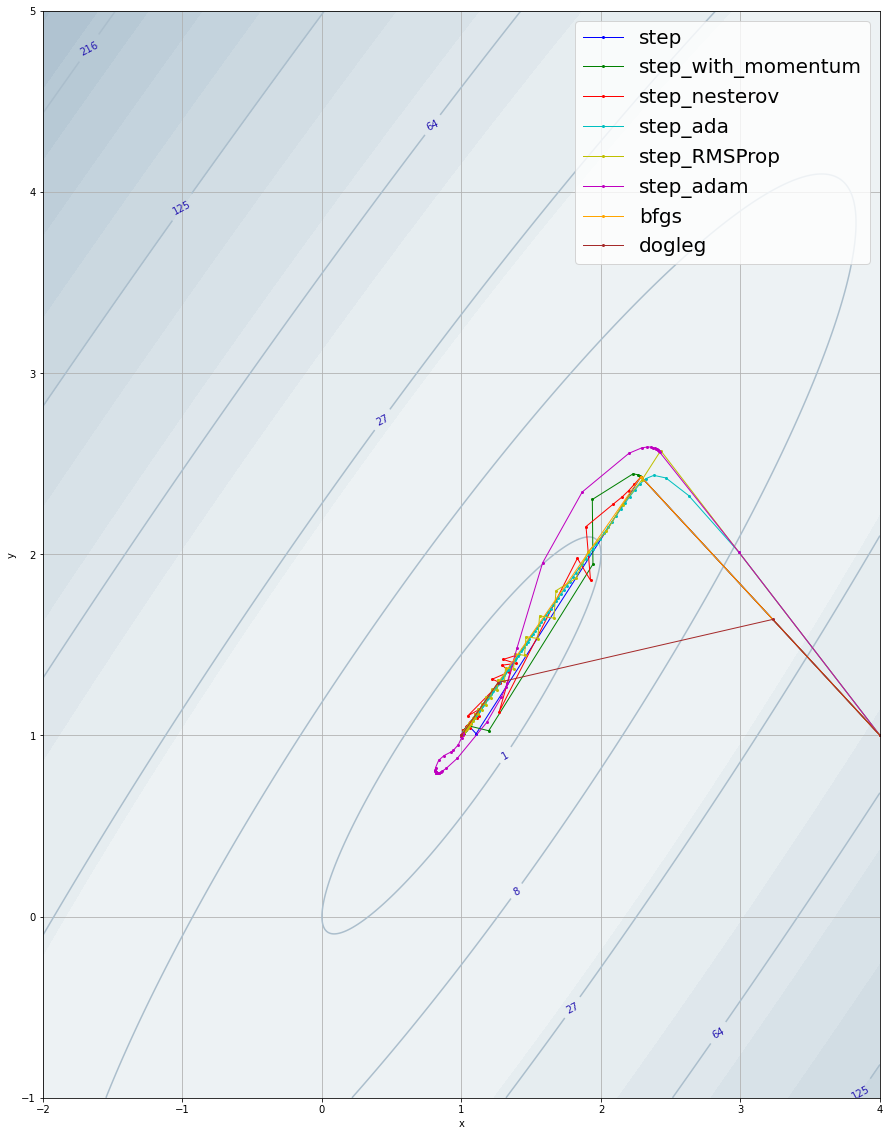

Стартовая точка: [3 5]
step                          	 Ответ : [1.00000546 1.00000595]. Количество операций : 24. Время : 16 миллисекунд. Память : 22.171 KB
step_with_momentum            	 Ответ : [1.00000515 1.00000537]. Количество операций : 34. Время : 23 миллисекунд. Память : 26.731 KB
step_nesterov                 	 Ответ : [1.00000429 1.00000456]. Количество операций : 59. Время : 87 миллисекунд. Память : 33.368 KB
step_ada                      	 Ответ : [1.00000679 1.00000759]. Количество операций : 268. Время : 184 миллисекунд. Память : 94.31 KB
step_RMSProp                  	 Ответ : [1.00000571 1.00000669]. Количество операций : 117. Время : 74 миллисекунд. Память : 66.643 KB
step_adam                     	 Ответ : [1.0000016  1.00000219]. Количество операций : 158. Время : 101 миллисекунд. Память : 82.557 KB
dogleg                        	 Ответ : [1. 1.]. Количество операций : 4. Время : 1 миллисекунд. Память : 6.584 KB
gauss-newton 0.9999999999999996 1.000000000931335 2
do

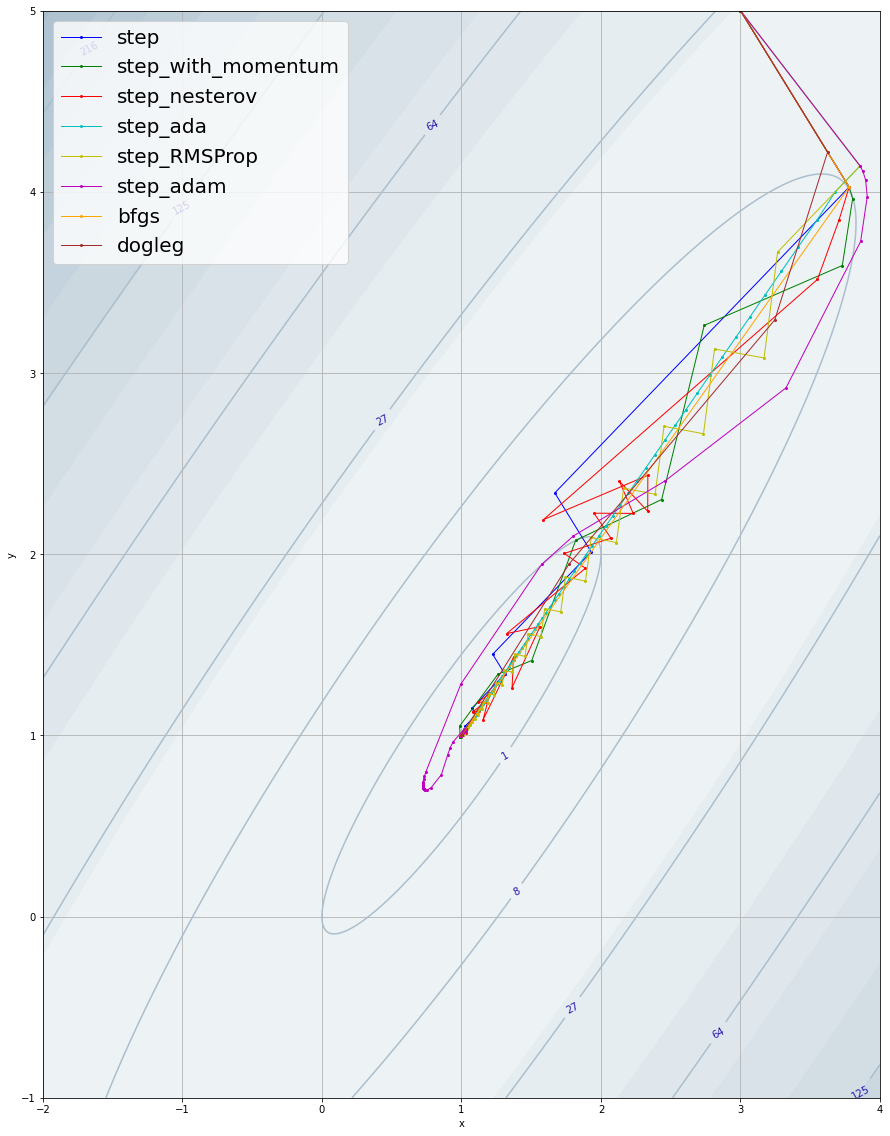

Стартовая точка: [ 1 10]
step                          	 Ответ : [1.00000105 1.00000116]. Количество операций : 10. Время : 8 миллисекунд. Память : 11.523 KB
step_with_momentum            	 Ответ : [1.00000259 1.0000027 ]. Количество операций : 37. Время : 22 миллисекунд. Память : 28.867 KB
step_nesterov                 	 Ответ : [1.00000512 1.00000589]. Количество операций : 62. Время : 87 миллисекунд. Память : 32.087 KB
step_ada                      	 Ответ : [1.000007   1.00000777]. Количество операций : 2218. Время : 1381 миллисекунд. Память : 429.252 KB
step_RMSProp                  	 Ответ : [1.00000537 1.00000624]. Количество операций : 106. Время : 68 миллисекунд. Память : 53.376 KB
step_adam                     	 Ответ : [1.00000446 1.00000509]. Количество операций : 198. Время : 123 миллисекунд. Память : 79.131 KB
dogleg                        	 Ответ : [1. 1.]. Количество операций : 4. Время : 1 миллисекунд. Память : 6.584 KB
gauss-newton 1.0 1.0 3
dogleg 1.0 1.0 5


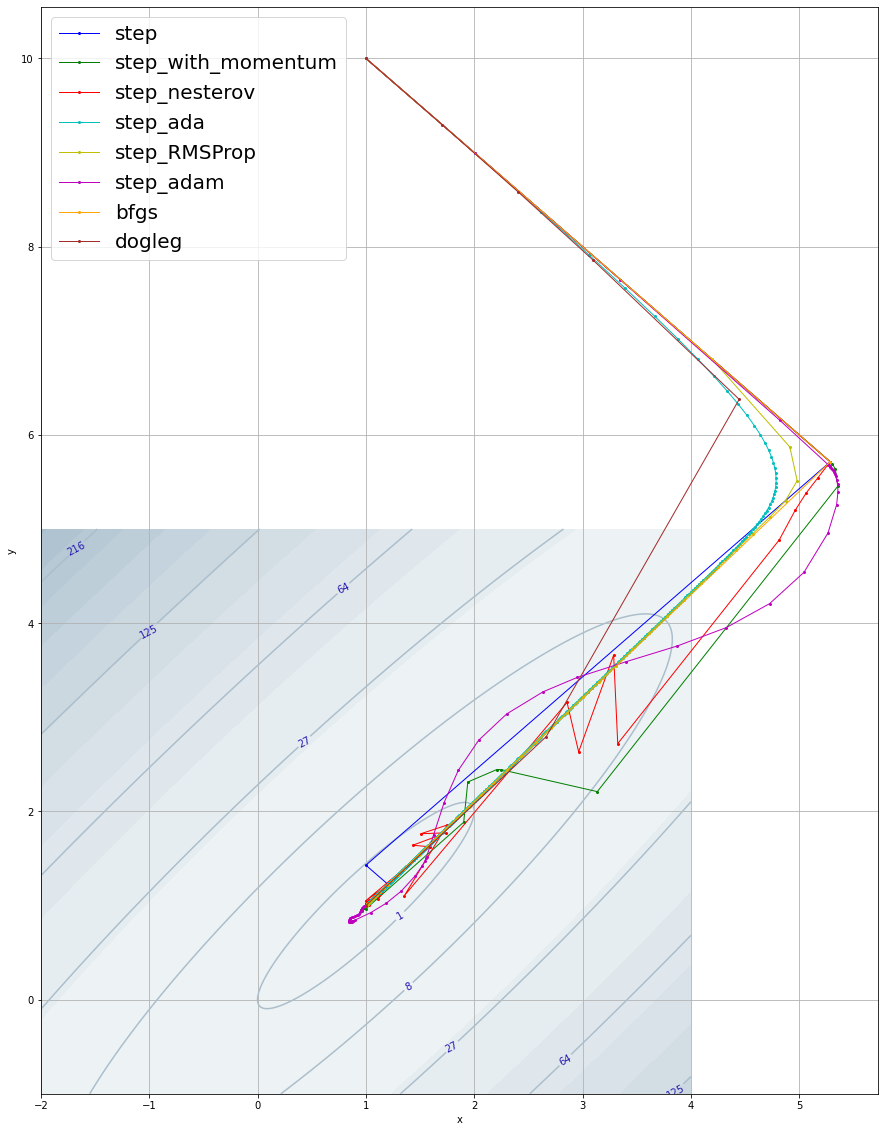

Стартовая точка: [ -1 -10]
step                          	 Ответ : [0.99999537 0.99999492]. Количество операций : 12. Время : 10 миллисекунд. Память : 14.491 KB
step_with_momentum            	 Ответ : [0.9999971  0.99999667]. Количество операций : 40. Время : 25 миллисекунд. Память : 31.223 KB
step_nesterov                 	 Ответ : [0.99999505 0.9999943 ]. Количество операций : 62. Время : 87 миллисекунд. Память : 32.256 KB
step_ada                      	 Ответ : [0.99999303 0.99999223]. Количество операций : 2283. Время : 1409 миллисекунд. Память : 422.149 KB
step_RMSProp                  	 Ответ : [0.99999519 0.99999514]. Количество операций : 136. Время : 84 миллисекунд. Память : 59.296 KB
step_adam                     	 Ответ : [0.99999584 0.99999526]. Количество операций : 199. Время : 127 миллисекунд. Память : 79.011 KB
dogleg                        	 Ответ : [1. 1.]. Количество операций : 4. Время : 2 миллисекунд. Память : 6.584 KB
gauss-newton 1.0000000000000002 1.000000000048

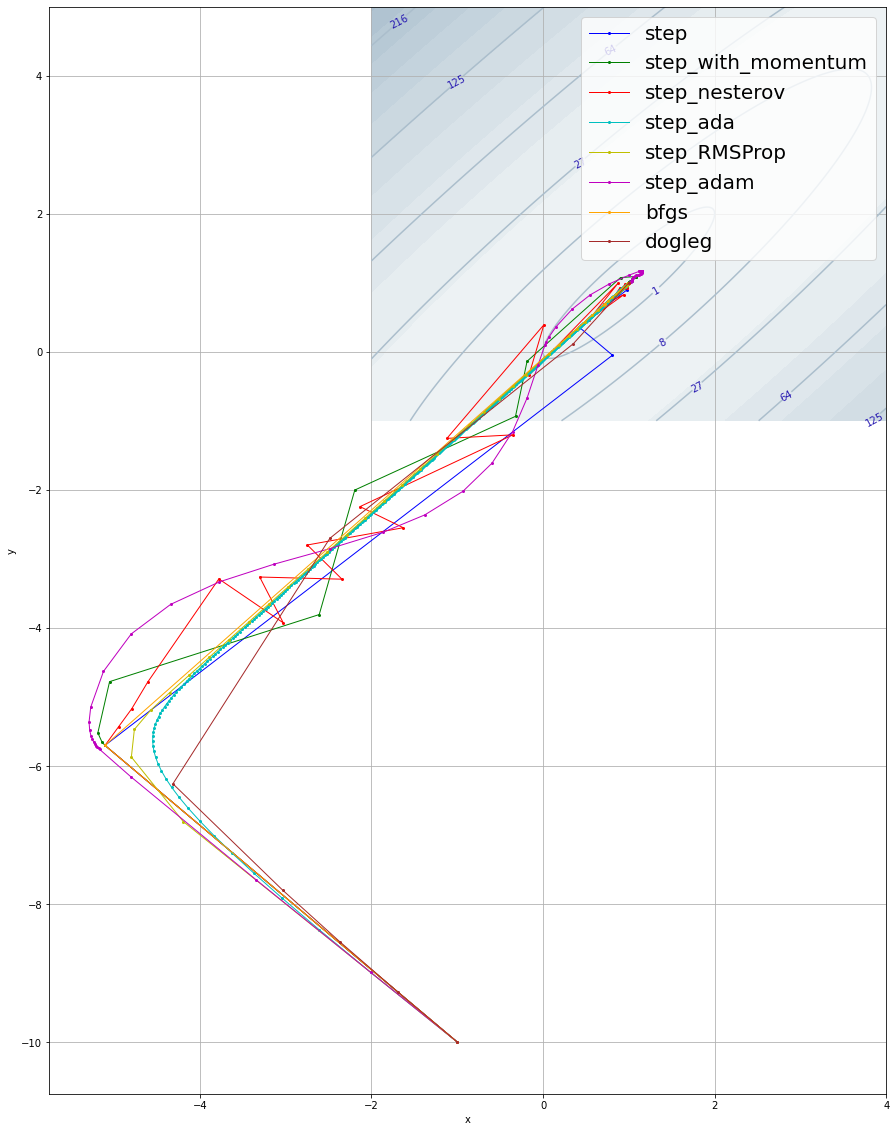

f = (100 * (y - x ^ 2) ^ 2 + (1 - x) ^ 2):
Стартовая точка: [0 0]
step                          	 Ответ : [0.99999046 0.99998088]. Количество операций : 9496. Время : 6713 миллисекунд. Память : 1698.633 KB
step_with_momentum            	 Ответ : [0.99999359 0.99998716]. Количество операций : 507. Время : 397 миллисекунд. Память : 125.799 KB
step_nesterov                 	 Ответ : [0.99998922 0.99997839]. Количество операций : 1051. Время : 1878 миллисекунд. Память : 217.547 KB
step_ada                      	 Ответ : [0.99999005 0.99998006]. Количество операций : 8138. Время : 6062 миллисекунд. Память : 1496.187 KB
step_RMSProp                  	 Ответ : [0.99998923 0.99997843]. Количество операций : 3100. Время : 2903 миллисекунд. Память : 548.278 KB
step_adam                     	 Ответ : [0.9999911  0.99998216]. Количество операций : 450. Время : 302 миллисекунд. Память : 113.254 KB
dogleg                        	 Ответ : [0.99999999 0.99999998]. Количество операций : 20. Время : 6 м

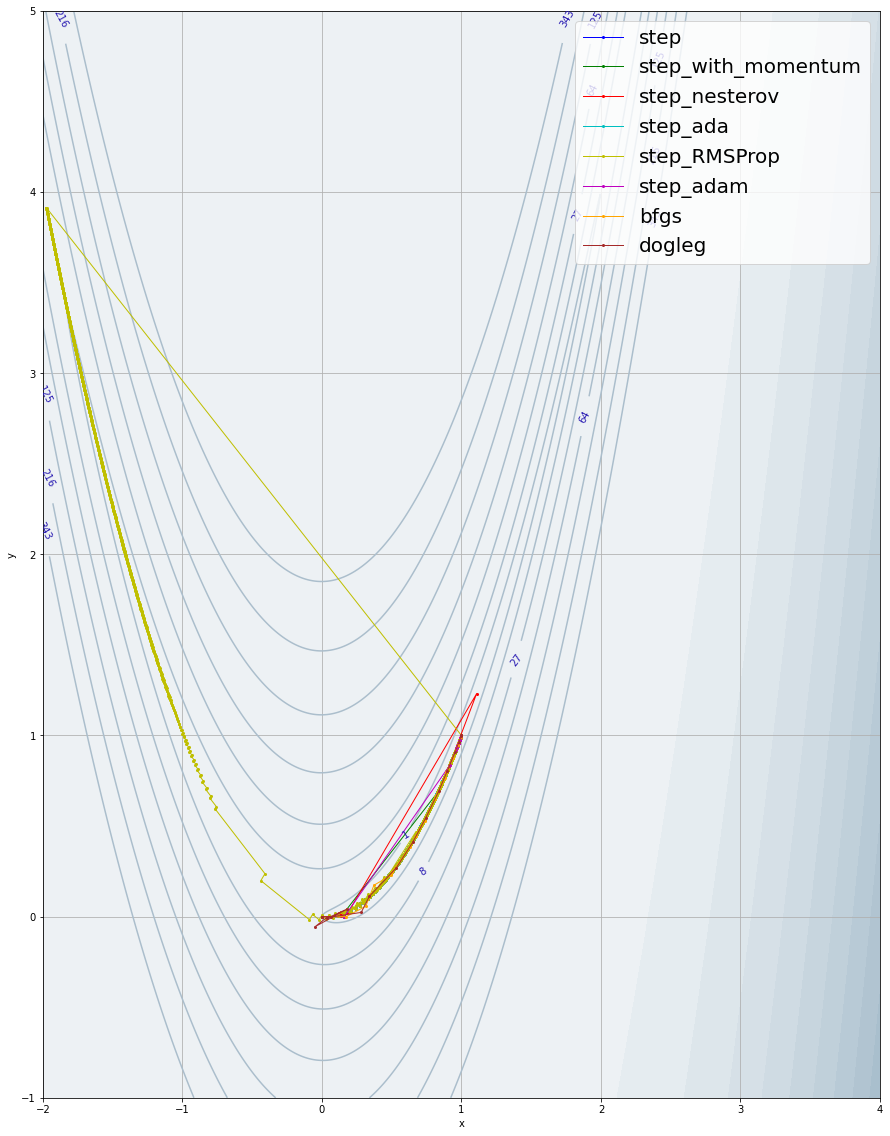

Стартовая точка: [-1  1]
step                          	 Ответ : [1.00000001 1.00000001]. Количество операций : 1. Время : 2 миллисекунд. Память : 7.707 KB
step_with_momentum            	 Ответ : [1.00000186 1.00000372]. Количество операций : 11. Время : 9 миллисекунд. Память : 10.308 KB
step_nesterov                 	 Ответ : [0.99998893 0.99997782]. Количество операций : 973. Время : 1629 миллисекунд. Память : 208.035 KB
step_ada                      	 Ответ : [0.9999889  0.99997775]. Количество операций : 1523. Время : 1052 миллисекунд. Память : 327.929 KB
step_RMSProp                  	 Ответ : [0.99999948 0.99999896]. Количество операций : 5. Время : 6 миллисекунд. Память : 6.139 KB
step_adam                     	 Ответ : [1.00000789 1.00001584]. Количество операций : 105. Время : 79 миллисекунд. Память : 73.275 KB
dogleg                        	 Ответ : [1. 1.]. Количество операций : 2. Время : 1 миллисекунд. Память : 6.584 KB
gauss-newton 1.0 1.0 25
dogleg 0.9999999999996231 0.9

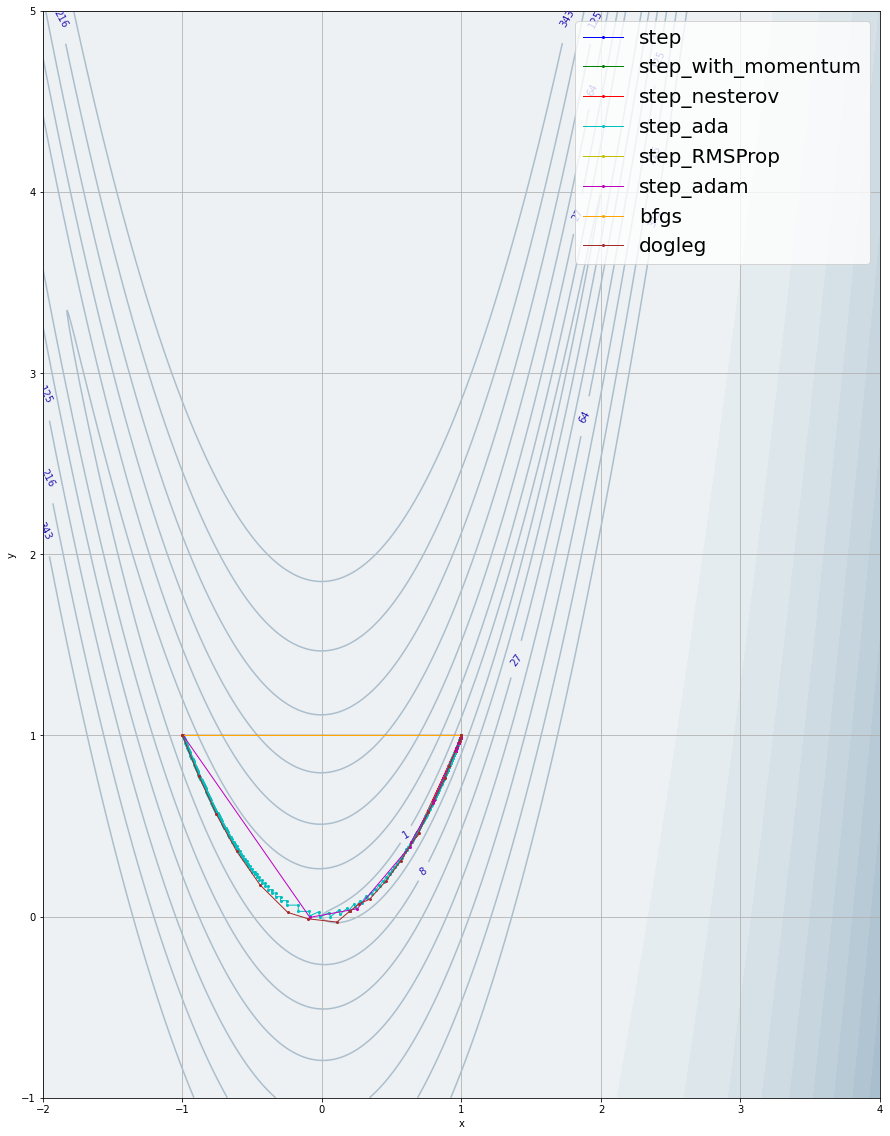

Стартовая точка: [2 3]
step                          	 Ответ : [1.0000081  1.00001623]. Количество операций : 1631. Время : 1316 миллисекунд. Память : 317.531 KB
step_with_momentum            	 Ответ : [1.00001005 1.00002014]. Количество операций : 4871. Время : 3453 миллисекунд. Память : 869.365 KB
step_nesterov                 	 Ответ : [1.00001094 1.00002193]. Количество операций : 917. Время : 1486 миллисекунд. Память : 209.395 KB
step_ada                      	 Ответ : [1.00000996 1.00001996]. Количество операций : 10698. Время : 7720 миллисекунд. Память : 1944.051 KB
step_RMSProp                  	 Ответ : [1.00000363 1.00000727]. Количество операций : 6140. Время : 4394 миллисекунд. Память : 1103.681 KB
step_adam                     	 Ответ : [1.00000763 1.00001531]. Количество операций : 558. Время : 405 миллисекунд. Память : 148.595 KB
dogleg                        	 Ответ : [1.         1.00000001]. Количество операций : 22. Время : 7 миллисекунд. Память : 6.584 KB
gauss-newto

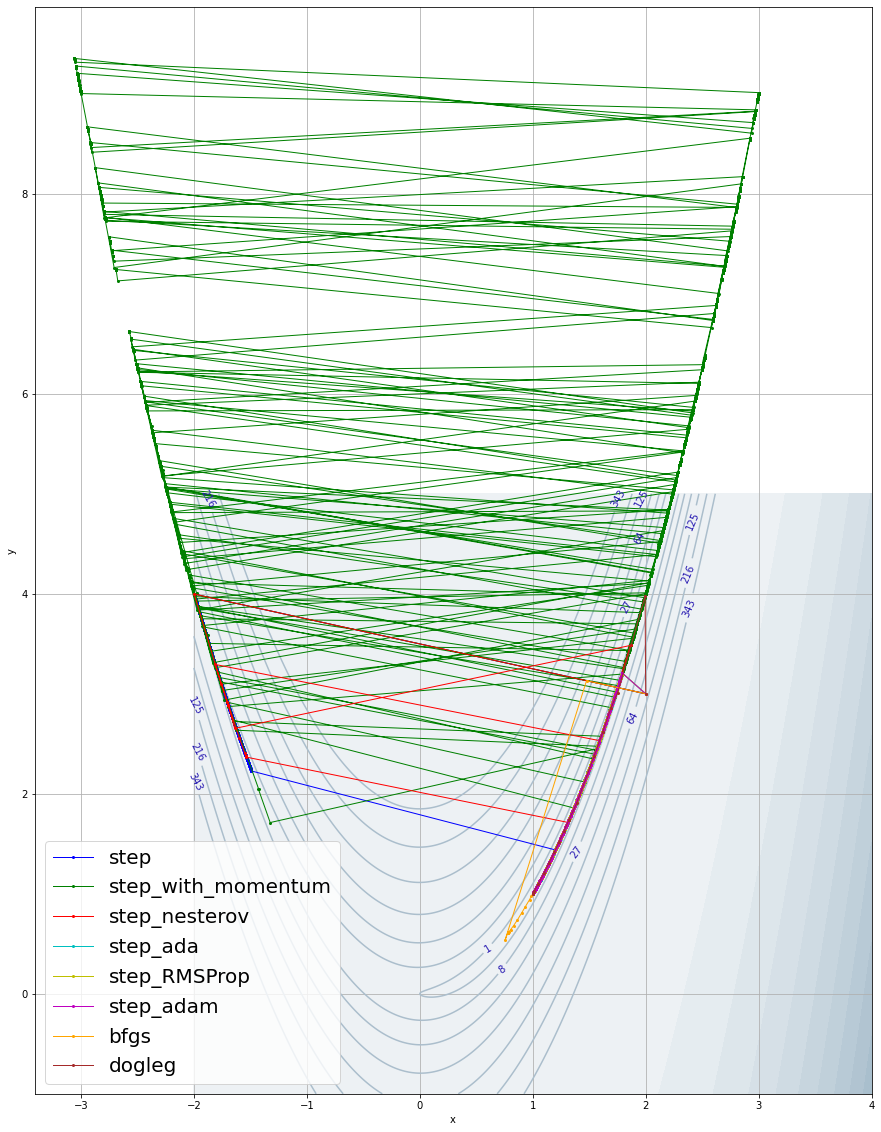

Стартовая точка: [4 1]
step                          	 Ответ : [1.00000821 1.00001645]. Количество операций : 69. Время : 48 миллисекунд. Память : 57.12 KB
step_with_momentum            	 Ответ : [1.00000922 1.00001848]. Количество операций : 1358. Время : 960 миллисекунд. Память : 262.764 KB
step_nesterov                 	 Ответ : [0.99999149 0.99998294]. Количество операций : 931. Время : 1505 миллисекунд. Память : 180.291 KB
[1.49838426 2.24607164]
step_ada                      	 Ответ : .... Количество операций : 20000. Время : 14135 миллисекунд. Память : 3565.339 KB
[1.00000022 0.99999978]
step_RMSProp                  	 Ответ : .... Количество операций : 20000. Время : 14347 миллисекунд. Память : 3557.683 KB
step_adam                     	 Ответ : [1.00000706 1.00001416]. Количество операций : 1029. Время : 719 миллисекунд. Память : 219.476 KB
dogleg                        	 Ответ : [1. 1.]. Количество операций : 59. Время : 17 миллисекунд. Память : 11.107 KB
gauss-newton 1.0 1.0

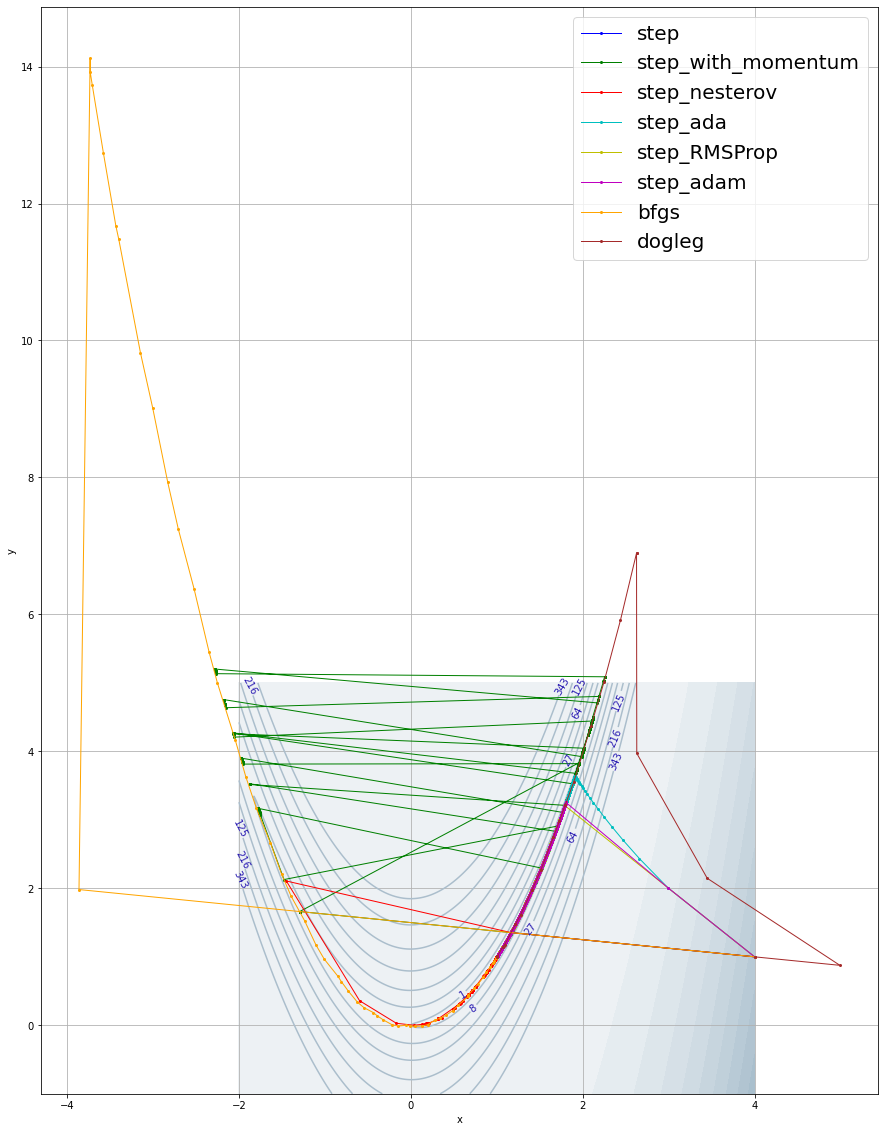

Стартовая точка: [3 5]
step                          	 Ответ : [1.00000818 1.0000164 ]. Количество операций : 3045. Время : 2239 миллисекунд. Память : 571.147 KB
step_with_momentum            	 Ответ : [1.00001039 1.00002081]. Количество операций : 1306. Время : 976 миллисекунд. Память : 266.803 KB
step_nesterov                 	 Ответ : [1.00000917 1.00001838]. Количество операций : 1218. Время : 2018 миллисекунд. Память : 227.142 KB
[1.03744878 1.07637541]
step_ada                      	 Ответ : .... Количество операций : 20000. Время : 14381 миллисекунд. Память : 3558.427 KB
step_RMSProp                  	 Ответ : [0.99999131 0.99998259]. Количество операций : 13944. Время : 11221 миллисекунд. Память : 2501.971 KB
step_adam                     	 Ответ : [1.00000818 1.0000164 ]. Количество операций : 774. Время : 586 миллисекунд. Память : 164.595 KB
dogleg                        	 Ответ : [1.00000001 1.00000001]. Количество операций : 46. Время : 15 миллисекунд. Память : 8.587 KB
gau

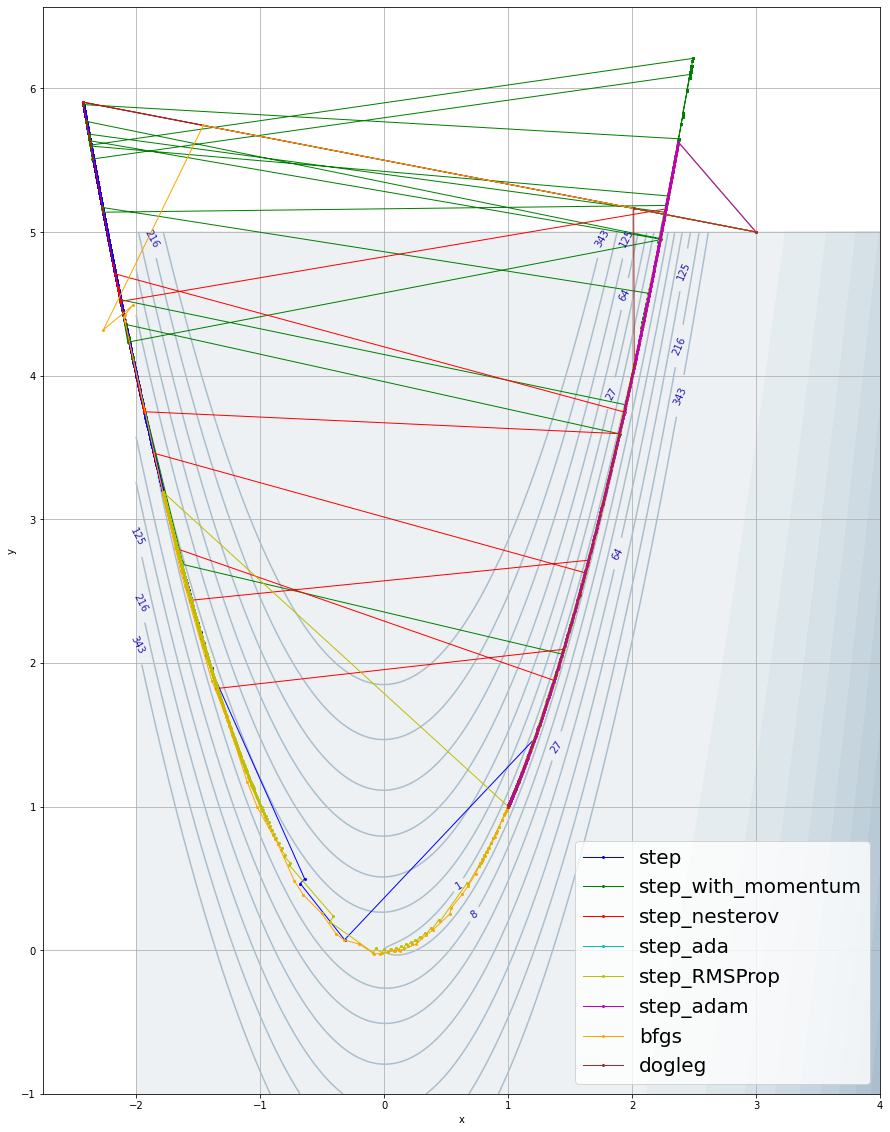

Стартовая точка: [ 1 10]
step                          	 Ответ : [1.00000819 1.00001641]. Количество операций : 3677. Время : 2619 миллисекунд. Память : 705.995 KB
step_with_momentum            	 Ответ : [1.00001019 1.00002043]. Количество операций : 7510. Время : 5535 миллисекунд. Память : 1387.739 KB
step_nesterov                 	 Ответ : [0.99998998 0.99997992]. Количество операций : 1319. Время : 2518 миллисекунд. Память : 278.411 KB
[1.85042909 3.42601411]
step_ada                      	 Ответ : .... Количество операций : 20000. Время : 15301 миллисекунд. Память : 3584.635 KB
[1.42103224 2.02161556]
step_RMSProp                  	 Ответ : .... Количество операций : 20000. Время : 14478 миллисекунд. Память : 3591.883 KB
step_adam                     	 Ответ : [1.00000033 1.00000066]. Количество операций : 1068. Время : 737 миллисекунд. Память : 227.276 KB
dogleg                        	 Ответ : [1.00000002 1.00000003]. Количество операций : 40. Время : 12 миллисекунд. Память : 8.3

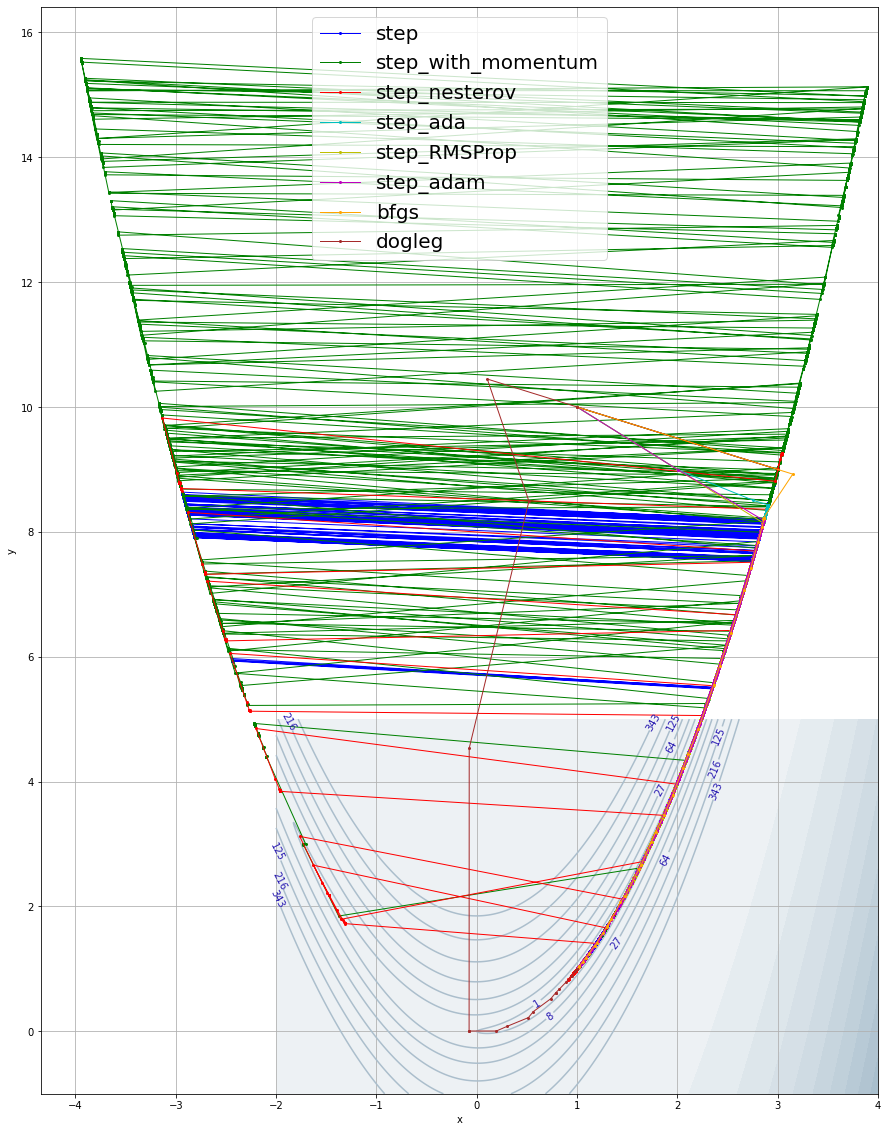

Стартовая точка: [ -1 -10]
step                          	 Ответ : [1.0000088  1.00001763]. Количество операций : 1663. Время : 1264 миллисекунд. Память : 341.723 KB
step_with_momentum            	 Ответ : [0.99998935 0.99997866]. Количество операций : 1287. Время : 1083 миллисекунд. Память : 264.633 KB
step_nesterov                 	 Ответ : [1.00001027 1.00002057]. Количество операций : 762. Время : 1445 миллисекунд. Память : 153.635 KB
[0.91491833 0.83668908]
step_ada                      	 Ответ : .... Количество операций : 20000. Время : 14004 миллисекунд. Память : 3567.611 KB
step_RMSProp                  	 Ответ : [0.99999899 0.99999797]. Количество операций : 3110. Время : 2115 миллисекунд. Память : 580.46 KB
step_adam                     	 Ответ : [0.99999357 0.99998712]. Количество операций : 922. Время : 638 миллисекунд. Память : 202.716 KB
dogleg                        	 Ответ : [1.         1.00000001]. Количество операций : 13. Время : 6 миллисекунд. Память : 6.584 KB
gaus

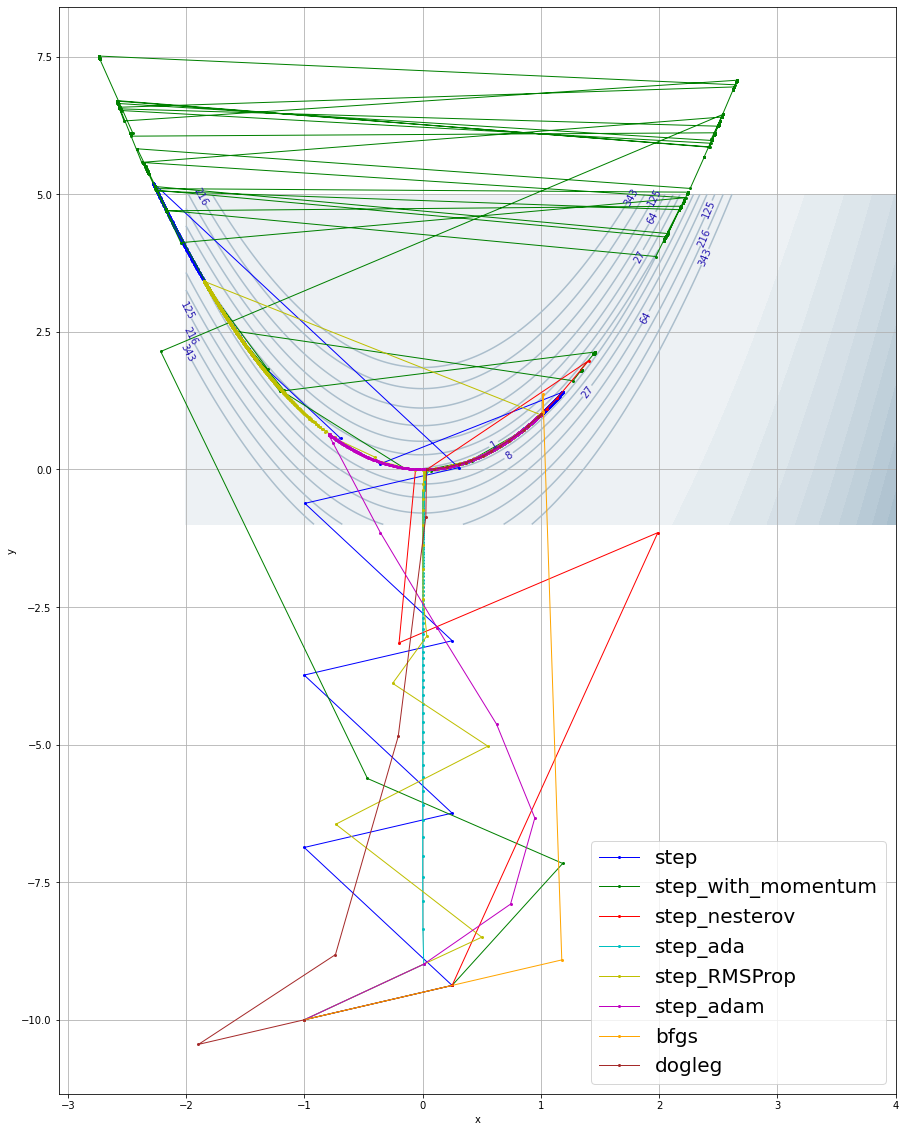

In [53]:

for i, f in enumerate(fs):
    print(f'f = {representations[i]}:')
    for s in starts:
        print("Стартовая точка:", s)
        tr = []
        for q in range(len(steps)):
            tracemalloc.start()
            start = datetime.datetime.now()
            oper, trace, x = common_gd(f, derivatives[i], s, golden_search, steps[q])
            end = datetime.datetime.now()
            _, memory = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            time = (end - start) / 1000
            memory /= 1000
            if x is None:
                ans = "..."
                print(trace[-1])
            else:
                ans = x
            tr.append(trace)
            print(f'{step_representation[q].ljust(30, " ")}\t Ответ : {ans}. Количество операций : {oper}. Время : {time.microseconds} миллисекунд. Память : {memory} KB')
        # try:
        tracemalloc.start()
        start = datetime.datetime.now()
        result, k, r = bfgs_method(fs_simple[i], derivatives_simple[i], s)
        if result is None:
            print("failure ", r[-1])
            ans = "..."
        else:
            ans = result
        end = datetime.datetime.now()
        _, memory = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        time = (end - start) / 1000
        memory /= 1000

        tr.append(r)
        print(f'{step_representation[-1].ljust(30, " ")}\t Ответ : {ans}. Количество операций : {k}. Время : {time.microseconds} миллисекунд. Память : {memory} KB')

        # print("result", result, k)

        result = least_squares(fs_simple2[i], np.array(s))
        print("gauss-newton", result.x[0], result.x[1], result.nfev)

        result, k, trace = trust_region_dogleg(fs_simple[i], derivatives_simple[i], hessians[i], s)
        tr.append(trace)
        print("dogleg", result[0], result[1], k)

        plot_all_graph(f, tr, step_representation)
